In [1]:
import pandas as pd
import SALib
from pathlib import Path
import os
import subprocess
import sys
import matplotlib.pyplot as plt
from IPython import display

To view this notebook as slides, run `jupyter nbconvert Tutorial.ipynb --to slides --post serve` on the command line

# ECEMP Skills Workshop: Global Sensitivity Analysis

- Will Usher, KTH Royal Institute of Technology
- Trevor Barnes, Simon Fraser University

# Introduction

## What is global sensitivity analysis?

- Global sensitivity analysis is “*the study of how uncertainty in the output of a model...can be apportioned to different sources of uncertainty in the model input*”. 
- “Global” means that all parameters are moved over their input ranges at the same time.
- By contrast, in one-at-a-time (OAT) sensitivity analysis, only one dimension of the model input space is explored while holding all other dimensions at their central value.
- An excellent introduction to global sensitivity analysis can be found in Saltelli (2007).

## Why perform global sensitivity analysis?

- Most energy system optimisation modelling studies use scenario analysis
- Global sensitivity analysis can supplement and support scenario analysis
  - identify key drivers of model results (factor prioritisation)
  - identify unimportant parameters (factor fixing)
  - identify interesting areas of the input space (factor mapping)

When models are used in a static manner, for example when influential parameters are held near a constant central value, these aspects of optimisation models – the apparent redundancy of parameters, lack of interaction effects and non-linear behaviour, may induce modellers to overlook parametric uncertainty. For example, modellers understandably tend to neglect the dimensions of the input space that are not represented in the results, resulting in parts of the model going “stale” as assumptions are not revisited or refreshed. On the other hand, modellers will commit a lot of attention to the parameters associated with technologies that do appear in the model results, even if those parameters are less influential than one of the static parameters.

## Methods for conducting global sensitivity analysis

Variance-based approaches compute the proportion of the variance in the output that is explained by variation in the input. 

- Computation of a first-order (only the direct effect) and total-order (direct and interaction effects) index for each input recovers all interaction and non-linear effects of a model. 
- Variance-based approaches require a relatively large number \$(500(k+2))\$ of model runs.

Elementary effects test, or “Method of Morris” lowers computationally needs \$(10(k+1))\$ by computing an average of local derivatives over a discrete space of input parameters.

- It provides an estimate for the total-order index produced by more advanced variance-based approaches 
- can be applied to groups of inputs to increase coverage and reduce computational demands.

# References

Andrea Saltelli, Marco Ratto, Terry Andres, Francesca Campolongo, Jessica Cariboni, Debora Gatelli, Michaela Saisana, and Stefano Tarantola. Global Sensitivity Analysis. The Primer. 1st ed. John Wiley & Sons, Ltd, 2007. https://doi.org/10.1002/9780470725184.


# Examples

## Example One

In this example, we will first show build a simple model and perform 
**LOCAL** sensitivity analysis

### Reference Energy System

Consider the simple energy system optimization model below. It includes: 

- A mining technology to introduce uranium 
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](./examples/Example_One/res.jpg)

### Input Data

We will add data for: 
- Capital Costs
- Fixed Costs
- Variable Costs (including fuel costs)
- Powerplant Efficiency 
- Powerplant Operational Life 
- Electricity Demand 

The model will be run given the assumptions: 
- Model horizon of 50 years 
- 8 equal time slices per year
- Linearly increaing yearly demand

In [2]:
# REFERENCE ONLY. 
# DATA ALREADY CREATED. 
# DO NOT CHANGE
data_dir = Path('./examples/Example_One/')

YEARS = range(2020, 2070)
TECHNOLOGIES = ['MINE_URANIUM', 'NUCLEAR']
FUELS = ['URANIUM', 'ELECTRICITY']
REGIONS = ['R1']
TIME_SLICE = ['S1D1', 'S1D2', 'S2D1', 'S2D2','S3D1','S3D2','S4D1','S4D2']
YEAR_SPLIT = 0.125
MODES = [1]

#### Add Capital Costs

In [3]:
def add_capex(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', years[0], cost]] * len(years), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'CapitalCost.csv'), index=False)
    return df

In [4]:
capex = 4000 # M$ / GW
add_capex(capex).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,4000
1,R1,NUCLEAR,2021,4000
2,R1,NUCLEAR,2022,4000
3,R1,NUCLEAR,2023,4000
4,R1,NUCLEAR,2024,4000


#### Add Fixed Operational Costs

In [5]:
def add_fixed(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', YEARS[0], cost]] * len(YEARS), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'FixedCost.csv'), index=False)
    return df

In [6]:
fixed = 50 # M$ / GW
add_fixed(fixed).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,50
1,R1,NUCLEAR,2021,50
2,R1,NUCLEAR,2022,50
3,R1,NUCLEAR,2023,50
4,R1,NUCLEAR,2024,50


#### Add Variable Costs

In [7]:
def add_variable(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'MINE_URANIUM', 1, years[0], cost]] * len(YEARS), 
        columns=['REGION','TECHNOLOGY','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'VariableCost.csv'), index=False)
    return df

In [8]:
variable = 2.5 # M$ / PJ
add_variable(variable).head()

,REGION,TECHNOLOGY,MODE_OF_OPERATION,YEAR,VALUE
0,R1,MINE_URANIUM,1,2020,2.5
1,R1,MINE_URANIUM,1,2021,2.5
2,R1,MINE_URANIUM,1,2022,2.5
3,R1,MINE_URANIUM,1,2023,2.5
4,R1,MINE_URANIUM,1,2024,2.5


#### Add Nuclear Power Plant Efficiency 

In [9]:
def add_efficiency(eff):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', 'URANIUM', 1, years[0], eff]] * len(years), 
        columns=['REGION','TECHNOLOGY','FUEL','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'InputActivityRatio.csv'), index=False)
    return df

In [10]:
eff = 1.25 # 80 %
add_efficiency(eff).head()

,REGION,TECHNOLOGY,FUEL,MODE_OF_OPERATION,YEAR,VALUE
0,R1,NUCLEAR,URANIUM,1,2020,1.25
1,R1,NUCLEAR,URANIUM,1,2021,1.25
2,R1,NUCLEAR,URANIUM,1,2022,1.25
3,R1,NUCLEAR,URANIUM,1,2023,1.25
4,R1,NUCLEAR,URANIUM,1,2024,1.25


#### Add Demand

In [11]:
def add_demand(start_value, yearly_increase):
    demand_data = []
    for year in range(2020, 2070):
        demand_data.append([
            'R1', 
            'ELECTRICITY',
            year,
            start_value*(1+yearly_increase)**(year-YEARS[0])
        ])
    df = pd.DataFrame(demand_data, columns=['REGION','FUEL','YEAR','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'SpecifiedAnnualDemand.csv'), index=False)
    return df

In [12]:
start_value = 1000 # PJ
yearly_increase = 0.05 # %
add_demand(start_value, yearly_increase).head()

,REGION,FUEL,YEAR,VALUE
0,R1,ELECTRICITY,2020,1000.00000
1,R1,ELECTRICITY,2021,1050.00000
2,R1,ELECTRICITY,2022,1102.50000
3,R1,ELECTRICITY,2023,1157.62500
4,R1,ELECTRICITY,2024,1215.50625


#### Add Operational Life

In [13]:
def add_operational_life(op_life):
    df = pd.DataFrame([['R1','NUCLEAR',op_life]], columns=['REGION','TECHNOLOGY','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'OperationalLife.csv'), index=False)
    return df

In [14]:
op_life = 50 # years
add_operational_life(op_life).head()

,REGION,TECHNOLOGY,VALUE
0,R1,NUCLEAR,50


### One-at-a-time Sensitivity Analysis

Run the model with the baseline input parameters and get a reference objective value

In [15]:
def run_model(path_to_data_dir, path_to_model_file, result_file_name):
    os.system(
        'otoole convert datapackage datafile {} {}' .format(
            Path(path_to_data_dir,'datapackage.json'), 
            Path(path_to_data_dir,'data.txt')
        )
    )
    os.system(
        'glpsol -m {} -d {} --wlp {} --check' .format(
            Path(path_to_model_file),
            Path(path_to_data_dir,'data.txt'),
            Path(path_to_data_dir,'model.lp'),
        )
    )
    os.system(
        'cbc {} solve -solu {}' .format(
            Path(path_to_data_dir,'model.lp'),
            Path(path_to_data_dir,result_file_name)
        )
    )

def get_objective_value(result_files):
    for result_file in result_files:
        print(f'{result_file.name}')
        os.system('head -1 {}' .format(Path(result_file)))

In [16]:
run_model(data_dir, './examples/Example_One/osemosys.txt', 'solution.sol')
get_objective_value([Path(data_dir, 'solution.sol')])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m examples/Example_One/osemosys.txt -d examples/Example_One/data.txt --wlp
 examples/Example_One/model.lp --check
Reading model section from examples/Example_One/osemosys.txt...
1124 lines were read
Reading data section from examples/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 170)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 185)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 190)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 195)...
Checking (

## Model Results

Solving the model for total discounted costs produces an objective value  of $572,721. In local sensitivity analysis, we select a single parameter to alter and rerun the model. This will tell us the effect that single parameter has on the results around the optimal location. 

### Parameter Changes

We will change both the **capital costs** and **variable costs** of the nuclear power plant to see how sensitive the results are to these parameters. We will do 5 additional runs for each parameter, resulting in 10 total runs. This summary of model runs and results are given below.  

| Run      | Capital Costs (M$/GW) | Variable Costs (M$/PJ) | Objective Cost (M$) |
|----------|-----------------------|------------------------|---------------------|
| Original | 4000                  | 2.5                    | 572721              |
| 1        | 2500                  | 2.5                    | 446506              |
| 2        | 3000                  | 2.5                    | 488577              |
| 3        | 3500                  | 2.5                    | 530649              |
| 4        | 4500                  | 2.5                    | 614793              |
| 5        | 5000                  | 2.5                    | 656865              |
| 6        | 4000                  | 1.5                    | 511727              |
| 7        | 4000                  | 2.0                    | 542224              |
| 8        | 4000                  | 3.0                    | 572721              |
| 9        | 4000                  | 3.5                    | 633715              |
| 10       | 4000                  | 4.0                    | 664212              |


In [17]:
result_files = []

# Iterate over capital cost
capital_costs = [2500, 3000, 3500, 4500, 5000]
for capital_cost in capital_costs:
    add_capex(capital_cost)
    result_file = f'capex_{capital_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, './examples/Example_One/osemosys.txt', result_file)

# resest to origianl capital cost
add_capex(4000)

# Iterate over variable cost
var_costs = [1.5, 2.0, 3.0, 3.5, 4.0]
for var_cost in var_costs:
    add_variable(var_cost)
    result_file = f'var_cost_{var_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, './examples/Example_One/osemosys.txt', result_file)

# reset to original variable cost
add_variable(2.5)

# extract objective costs
get_objective_value(result_files)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m examples/Example_One/osemosys.txt -d examples/Example_One/data.txt --wlp
 examples/Example_One/model.lp --check
Reading model section from examples/Example_One/osemosys.txt...
1124 lines were read
Reading data section from examples/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 170)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 185)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 190)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 195)...
Checking (

Create simple plots to see how the costs change with parameters

In [18]:
def plot_LSA(df_capex, df_var):
    fig, axs = plt.subplots(1,2, figsize=(14,5), sharey=True)
    df_capex.plot(ax=axs[0], marker='o', title='Effects of Capital Cost', xlabel='Capital Cost (M$/GW)', ylabel='Objective Cost (M$)')
    df_var.plot(ax=axs[1], marker='o', title='Effects of Variable Cost', xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)')

In [19]:
df_capex = pd.DataFrame([
    [2500, 446506],
    [3000, 488577],
    [3500, 530649],
    [4000, 572721],
    [4500, 614793],
    [5000, 656865],
], columns=['Capex', 'Objective_Cost']).set_index('Capex')

df_var = pd.DataFrame([
    [1.5, 511727],
    [2.0, 542224],
    [2.5, 572721],
    [3.0, 603218],
    [3.5, 633715],
    [4.0, 664212],
], columns=['Var_Cost', 'Objective_Cost']).set_index('Var_Cost')

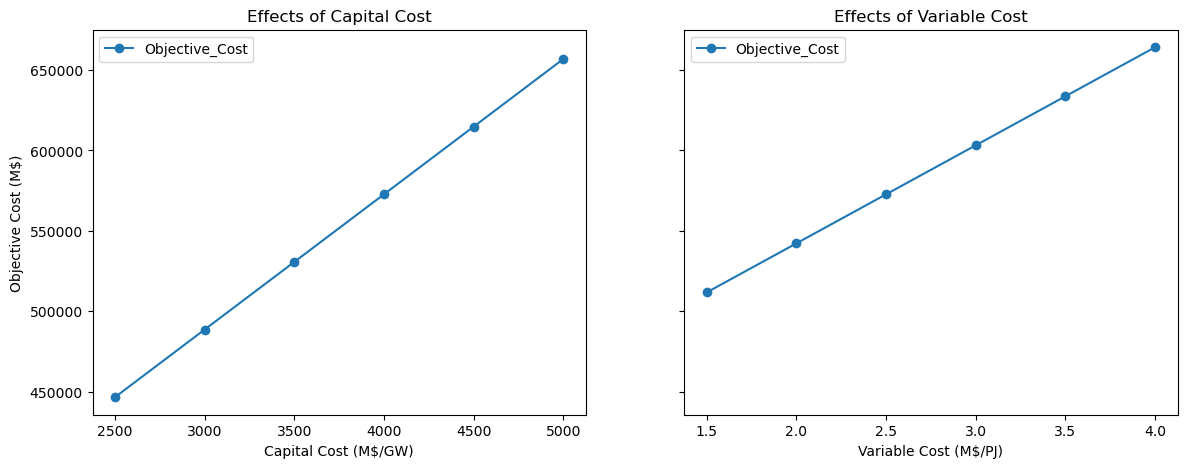

In [20]:
plot_LSA(df_capex, df_var)

## Shortfalls with local sensitivity analysis

### Parameter Influence
In this example, we can see that capital costs are the more influential parameter over our range of values, due to it having a steeper gradient. However, as we add more parameters and build more complex models, simply viewing the gradient can become impractical. 

### Interaction Effects
This example also shows a relatively linear responce between our varaibles and objective cost. While non-linear effects would also be captured by this method, interaction effects would not be. For example, variable costs (which include fuel cost) and the efficiency of the power plant will interact (as discussed later). We do not see this interaction through local sensitivity analysis. 

## Example Two 

We will repeat example one, except employ **GLOBAL** sensitivity analysis using the Method of Morris.

## Reference Energy Systen

Our RES and included parameters will remain the same as example 1. 

![RES](./examples/Example_Two/res.jpg)

## The Workflow

Performing global sensitivity analysis requires running the model many times and carful handeling of the results. Therfore, it is benifical to set up an automated workflow to reduce data handlling errors. To execute the workflow, three main steps are required. 

1. Modify a configuration file
2. Run the workflow 
3. Assess results

A high-level graphical overview of the the workflow is given below. 


![workflow](./examples/Example_Two/workflow.jpg)


## The Configuration File

The configuration file contains parameters that define how the sensitivity analysis will be conducted. For each factor we want to test, we can test its sensitivity independently of time. Moreover, if the parameter is defined over time (such as a yearly changing demand), we can also test the sensitivity dependent on time. 

### Time Independent Factors 

The figure below highlights two different scenarions that can be configured in the workflow. The red lines prepresent the user inputted bounds, while the green lines represnet the modelled values. 

![gsa-options](./examples/Example_Two/gsa_options_fixed.jpg)


### Scenario One
In scenario one, we specify a fixed start point. This results in **no sensitivity analysis** being performed, because we are not varrying the parameter over different model runs. 

### Scenario Two
In scenario two, we specify a moving start point, represented by the red bars. This can be benifical in situations where we know the parameter value will not change throughout the model run, but want to test the sensitivity of this fixed value. For example, the operational life of a powerplant. 

### Time Dependent Factors 

The figure below highlights three different scenarions that can be configured in the workflow. The red lines prepresnet the user inputted bounds, while the green lines represnet the interpoloated values. 

![gsa-options](./examples/Example_Two/gsa_options_interpolate.jpg)


### Scenario One
In scenario one, we specify fixed start and end points. This results in **no sensitivity analysis** being performed, because we are not varrying the parameter over different model runs. 

### Scenario Two
In scenario two, we specify a fixed start point, and a moving end point. This can be benifical in scenario where we know the starting value, but are uncertian about how the value will change in time. For example, the annual demand of our start year may be a known value, but we are uncertain how will progress throughout the model horizon. 

### Scenario Three
In scenario three, we specify moving start and end pointns. This can be benifical in scenarios where we want to test the sensitivity of values where we are uncertain of both current and future values. For example, fuel costs are always changing, and testing the sesitivity of these changes on your model can give insights. 

Navigate to `config/scenarios.csv` file and update it to match the following:


| name | description      | path                             |
|------|------------------|----------------------------------|
|0     | "Simple Example" | examples/assets/datapackage.json |

### Modify the Configuration File

Navigate to [`examples/Example_Two/parameters.csv`](/edit/examples/Example_Two/parameters.csv) file and add sensitivity parameters for the `CapitalCost`, `VariableCost`, and `InputActivityRatio` (defined as 1/efficiency). The formatted parameter csv should look similar to the following. The `interploation_index` value is either `fixed` or `interpolate` for time independent and time dependent parameters respectively. 

Feel free to user your own values for the min/max values!



|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost  |capital  |"R1,NUCLEAR"        |4000 |5000 |2000 |3000 |"unif" |"YEAR" |"interpolate" |
|VariableCost |variable |"R1,MINE_URANIUM,1" |3.5  |4.0  |1.5  |1.75 |"unif" |"YEAR" |"interpolate" |
|InputActivityRatio | IAR |"R1,NUCLEAR,URANIUM,1" |1.3 | 1.5 | 1.05 | 1.2 | "unif" | "YEAR" | "interpolate" |

### Run the Workflow

Once we have defined our sensitivity parameters, we can run the workflow

In [21]:

"""
def clean_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake --cores 4 clean", cwd="..", shell=True)
def run_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake --cores 4", cwd="..", shell=True)

clean_snakemake()
run_snakemake()
"""

'\ndef clean_snakemake():\n    wd = sys.path[0]\n    os.chdir(wd)\n    subprocess.Popen("snakemake --cores 4 clean", cwd="..", shell=True)\ndef run_snakemake():\n    wd = sys.path[0]\n    os.chdir(wd)\n    subprocess.Popen("snakemake --cores 4", cwd="..", shell=True)\n\nclean_snakemake()\nrun_snakemake()\n'

In [22]:
!snakemake clean -c --configfile examples/Example_Two/config.yaml
!snakemake --cores 4 --configfile examples/Example_Two/config.yaml

Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 4
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job      count    min threads    max threads
-----  -------  -------------  -------------
clean        1              1              1
total        1              1              1

Checking user inputs...
Select jobs to execute...

[Tue Oct  4 14:18:49 2022]
localrule clean:
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

[Tue Oct  4 14:18:53 2022]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2022-10-04T141842.536234.snakemake.log
Workflow finished successfully!
Config file config/config.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided

## View Results 

The global sensitivity anlysis conducted is called The Method of Morris. This screening method will produce three sensitivity values of interest, mu, mu*, and sigma.

- mu will assess the overall influence of the factor on the output
- mu* will estimate the mean of the distribution of the absolute values 
- Sigma, the standard deviation, will estimate the nonlinear effects and/or interactions with other factors

The purpose of calculating mu* in addition to mu is that mu may fail to identify a factor with considerable influence on the model. This can happen when both positive and negative distributions. 

### Tabular Results

Tabluar results are found in the file ['results/SA_0.csv'](./results/0_summary/SA_0.csv)

In [25]:
pd.read_csv('results/SA_0.csv', index_col=0)

,mu,mu_star,sigma,mu_star_conf
capital,84367.020211,84367.020211,4.719110e-09,2.701598e-09
variable,23527.957812,23527.957812,1.547639e+03,9.000672e+02
IAR,23866.190430,23866.190430,1.749865e+03,1.050887e+03


### Graphical Results

Graphical results are found in the file ['results/0_summary/SA_objective.png'](./results/0_summary/SA_objective.png)

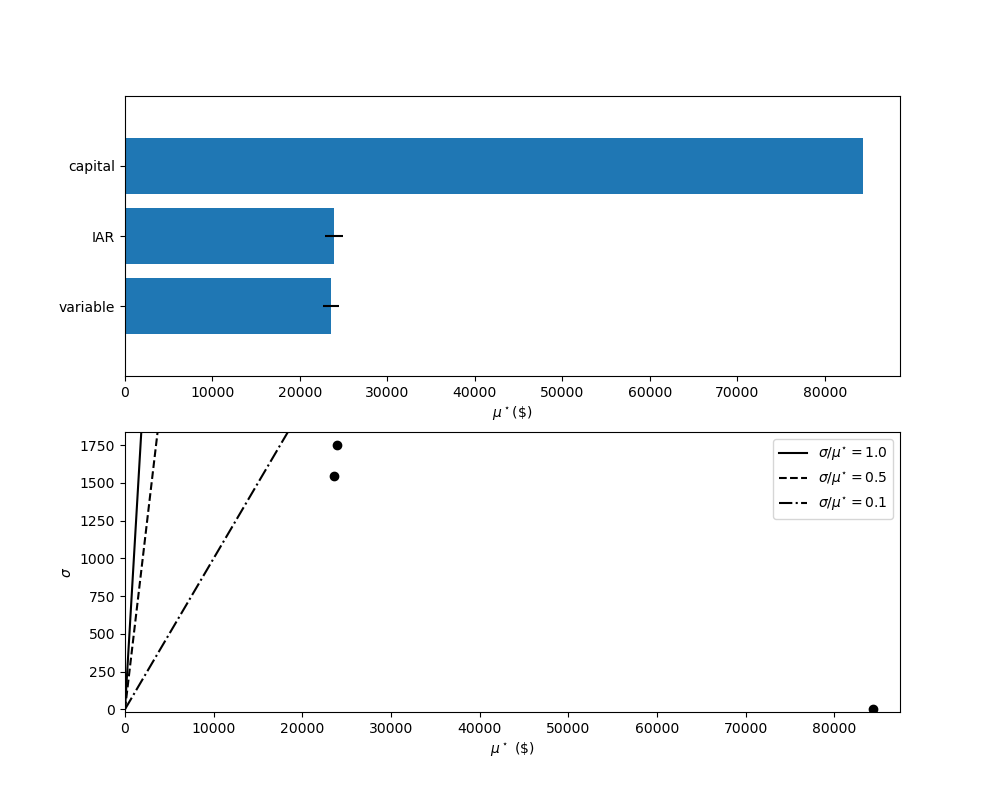

In [26]:
display.Image('./results/SA_0.png')

### Interpreting Results

Capital costs are most influentional factor, of the ones tested, on the total discounted cost of the system. There is no interaction between capital costs and variable costs or input activity ratio. Variable costs and the input activity ratio have non-linear effects and/or interact with each other. 

## Example 3

In this example, it's now up to you to modify the sensitivity paramters ! 

### Reference Energy Systen

Our RES and included parameters will remain the same. 

![RES](./examples/Example_Three/res.jpg)

### Modify the Configuration File

Navigate to [`examples/Example_Three/parameters.csv`](/edit/examples/Example_Three/parameters.csv) file and add sensitivity parameters. The available parameters to explore are shown below. Modify the configuration file however you want ! 

|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost           |capital  |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|FixedCost             |fixed    |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|VariableCost          |variable |"R1,MINE_URANIUM,1"         |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|SpecifiedAnnualDemand |demand   |"R1,ELECTRICITY"            |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|InputActivityRatio    |iar      |"R1,NUCLEAR,URANIUM,1"      |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |
|OperationalLife       |oplife   |"R1,NUCLEAR"                |XXX |XXX |XXX |XXX |"unif" |"YEAR" |"interpolate" |

### Run the Workflow

In [ ]:
!snakemake clean -c --configfile examples/Example_Three/config.yaml
!snakemake --cores 4 --configfile examples/Example_Three/config.yaml

### View Results

In [ ]:
pd.read_csv('results/SA_0.csv', index_col=0)

In [ ]:
display.Image('./results/SA_0.png')

# Wrapup 

In this tutorial we have explored how global sensitivity analysis can be applied to energy system optimization models. Specifically, we looked at the Method of Morris to identify influential parameters  and parameters  that have non-linear and/or interaction with other parameters. Oppose to local sensitivity analysis, global sensitivity analysis allows us explore a wide array of the solution space and identify the important factors. 

While in this example, we looked at the sensitivity on the total discounted system cost, we can perform sensitivity analysis on any variable of interest. For example, capacity installations, emission rates, or fuel usage. 

Finally, we used the Method of Morris to conduct our sensitivity analysis as it allows us to extract sufficient preliminary sensitivity indicators with minimal model runs. This is beneficial as (especially energy system optimization models) can often have multi-hour run times. However, other variance based global sensitivity methods can provide more information on the sensitivity of the results, with the caveat that this often requires more model runs. 